In [44]:
import numpy as np
import pandas as pd
import torch
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid
import torch_geometric.nn as gnn

## CiteSeer overview

In [45]:
dataset = Planetoid(root='../data/', name='CiteSeer')
data = dataset[0]
data

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])

Text(0.5, 0, 'Count')

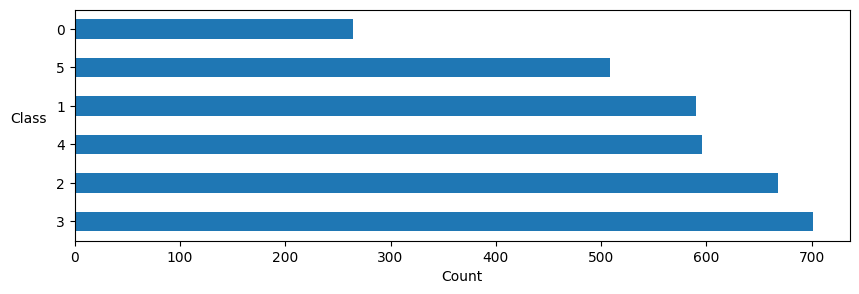

In [46]:
pd.Series(data.y).value_counts(sort=True).plot(kind='barh', figsize=(10, 3))
plt.ylabel('Class', rotation=0, labelpad=20)
plt.xlabel('Count')

In [47]:
print(f'{dataset.num_classes=}\n{dataset.num_features=}\n{data.num_nodes=}\
      \n{data.is_directed()=}\n{data.has_isolated_nodes()=}')

dataset.num_classes=6
dataset.num_features=3703
data.num_nodes=3327      
data.is_directed()=False
data.has_isolated_nodes()=True


In [48]:
not_isolated = pd.Series(data.edge_index[0]).unique().size
isolated_nodes_count = data.num_nodes - not_isolated
print(f'{isolated_nodes_count=}')

isolated_nodes_count=48


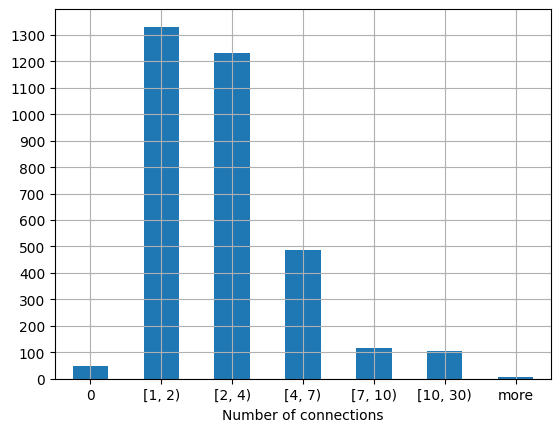

In [67]:
def to_categorical(el):
    quantiles = [1, 2, 4, 7, 10, 30, 60]
    for i in range(len(quantiles) - 1):
        if (el < quantiles[i]):
            return f'[{quantiles[i-1]}, {quantiles[i]})'
    return 'more'

connections = pd.Series(data.edge_index[0]).value_counts().apply(to_categorical)
connections = pd.concat([
    pd.Series({'0': isolated_nodes_count}),
    connections.value_counts()
])

connections.plot(kind='bar', grid=True)
plt.xticks(rotation=0);
plt.xlabel('Number of connections')
plt.yticks(np.arange(0, 1400, 100));

## Implementing a Graph Attention Network (GAT)